# Functions

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suprime todos os avisos
warnings.filterwarnings("ignore")

# Função 1: Gera o dataset com as colunas Individuo, Antes, Depois
def gerar_dataset(n=10, media_antes = 36.8, desv_antes = 0.3, media_depois=37.8, desv_depois = 0.15, seed=None):
    if seed is not None:
        np.random.seed(seed)
    antes = np.round(np.random.normal(media_antes, desv_antes, n), 2)
    depois = np.round(np.random.normal(media_depois, desv_depois, n), 2)
    df = pd.DataFrame({
        "Individuo": np.arange(1, n + 1),
        "Antes": antes,
        "Depois": depois
    })
    return df

# Função 2: Calcula colunas necessárias para o teste de Wilcoxon
def calcular_colunas_wilcoxon(df):
    df = df.copy()
    df["Diferença"] = df["Depois"] - df["Antes"]
    df["Absoluto"] = df["Diferença"].abs()
    df["Sinal"] = df["Diferença"].apply(lambda x: '+' if x > 0 else ('-' if x < 0 else '0'))
    # Calcula os postos (ranks) ignorando diferenças nulas
    df_nonzero = df[df["Diferença"] != 0].copy()
    df_nonzero["Posto"] = df_nonzero["Absoluto"].rank(method="average")
    # Posto com sinal: positivo ou negativo conforme a diferença
    df_nonzero["PostoSinal"] = df_nonzero.apply(
        lambda row: row["Posto"] if row["Sinal"] == '+' else -row["Posto"], axis=1
    )
    # Merge de volta ao DataFrame original
    df = df.merge(df_nonzero[["Individuo", "Posto", "PostoSinal"]], on="Individuo", how="left")
    return df

# Função 3: Aplica o teste de Wilcoxon e retorna estatísticas
def aplicar_teste_wilcoxon(df, alpha=0.05):
    df_valid = df[df["Diferença"] != 0]
    n = len(df_valid)

    # Calcula estatística de Wilcoxon
    stat, p = wilcoxon(df_valid["Depois"], df_valid["Antes"], alternative="two-sided")

    # Soma dos postos positivos e negativos
    T_positivo = df_valid[df_valid["Diferença"] > 0]["Posto"].sum()
    T_negativo = df_valid[df_valid["Diferença"] < 0]["Posto"].sum()
    T_min = min(T_positivo, T_negativo)

    # Valores críticos de W para teste bicaudal a 5% e 1% (n <= 20)
    tabela_criticos = {
        5:  {0.05: 0,  0.01: 0},
        6:  {0.05: 2,  0.01: 0},
        7:  {0.05: 3,  0.01: 1},
        8:  {0.05: 5,  0.01: 2},
        9:  {0.05: 8,  0.01: 3},
        10: {0.05: 10, 0.01: 5},
        11: {0.05: 13, 0.01: 7},
        12: {0.05: 17, 0.01: 10},
        13: {0.05: 21, 0.01: 13},
        14: {0.05: 25, 0.01: 17},
        15: {0.05: 30, 0.01: 21},
        16: {0.05: 35, 0.01: 25},
        17: {0.05: 40, 0.01: 30},
        18: {0.05: 46, 0.01: 35},
        19: {0.05: 52, 0.01: 40},
        20: {0.05: 59, 0.01: 46},
    }

    W_critico = tabela_criticos.get(n, {}).get(alpha, None)

    resultado = {
        "n pares válidos": n,
        "W (estatística)": stat,
        "p-valor": p,
        "T+": T_positivo,
        "T-": T_negativo,
        "T (min)": T_min,
        f"W crítico (α={alpha})": W_critico,
        "Rejeita H0?": T_min <= W_critico if W_critico is not None else "usar p-valor"
    }

    return resultado

# Função 4: Cria o boxplot
def plotar_boxplot(df):
    df_plot = pd.melt(df, id_vars="Individuo", value_vars=["Antes", "Depois"],
                      var_name="Tempo", value_name="Valor medido")
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_plot, x="Tempo", y="Valor medido", hue="Tempo", palette="pastel", legend=False)
    sns.swarmplot(data=df_plot, x="Tempo", y="Valor medido", color="black", size=5)
    plt.title("Antes e Depois")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
# Função para plotar a distribuição das temperaturas antes e depois
def plotar_distribuicoes(df):
    df_plot = pd.melt(df, id_vars="Individuo", value_vars=["Antes", "Depois"],
                      var_name="Tempo", value_name="Valor medido")
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(data=df_plot, x="Valor medido", hue="Tempo", kde=True,
                 bins=10, palette="pastel", element="step", stat="density", ax=ax)
    ax.set_title("Distribuição dos valores medidos antes e depois do tratamento")
    ax.set_xlabel("Valor medido")
    ax.set_ylabel("Densidade")
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.close(fig)
    return fig

# Teste de Wilcoxon


## Testes Paramétricos vs. Testes Não Paramétricos

Na estatística inferencial, os testes podem ser divididos em duas grandes categorias: **testes paramétricos** e **testes não paramétricos**. Os **testes paramétricos** partem da suposição de que os dados seguem uma determinada distribuição teórica, geralmente a distribuição normal. Eles operam sobre parâmetros populacionais como a média ($\mu$) e a variância ($\sigma^2$) e exigem condições como independência, homogeneidade de variâncias e normalidade das amostras. Exemplos clássicos incluem o teste $t$ de Student, a ANOVA e a regressão linear. Por outro lado, os **testes não paramétricos** não assumem uma distribuição específica para os dados e são baseados em ordenações, postos ou sinais. Esses testes são mais robustos e apropriados quando se trabalha com **pequenas amostras**, **dados assimétricos**, **nível ordinal** ou com presença de **outliers**. Em vez de testar hipóteses sobre médias, eles geralmente avaliam propriedades como **medianas** ou **distribuições empíricas**. Exemplos incluem o teste de Wilcoxon, o teste de Mann–Whitney, e o teste de Kruskal–Wallis. A escolha entre testes paramétricos e não paramétricos deve considerar tanto as características dos dados quanto os pressupostos do modelo estatístico adotado.

## Vantagens e Desvantagens

Os **testes paramétricos** oferecem **maior poder estatístico** quando seus pressupostos são atendidos, ou seja, eles são mais sensíveis para detectar diferenças reais quando os dados são normalmente distribuídos e a variância é homogênea. Além disso, eles permitem inferências mais específicas sobre parâmetros populacionais, como a média ($\mu$). No entanto, sua principal desvantagem é a **dependência rígida desses pressupostos**: se os dados forem assimétricos, contiverem outliers ou tiverem variâncias heterogêneas, o uso de testes paramétricos pode levar a conclusões errôneas. 

Já os **testes não paramétricos** são **mais robustos** nessas situações. Eles não exigem que os dados sigam distribuições específicas e podem ser aplicados a variáveis ordinais ou mesmo em casos de amostras pequenas. A principal desvantagem dos testes não paramétricos é que eles tendem a ter **menor poder estatístico** em comparação com os testes paramétricos, quando os pressupostos destes são válidos. Além disso, como operam sobre postos e não sobre os valores brutos, podem perder informações quantitativas relevantes. Assim, a escolha entre testes paramétricos e não paramétricos envolve um **equilíbrio entre robustez e sensibilidade**, considerando as características empíricas dos dados em análise.


## Introdução ao Teste de Wilcoxon para Amostras Pareadas

O teste de Wilcoxon para amostras pareadas, também conhecido como **teste dos postos com sinais de Wilcoxon**, é um procedimento estatístico **não paramétrico** utilizado para comparar duas condições medidas sobre os **mesmos indivíduos**, ou seja, **dados pareados**. É uma alternativa ao teste $t$ pareado de Student quando **não se pode assumir normalidade** das diferenças entre os pares. Esse teste é especialmente útil em contextos em que se deseja avaliar o **efeito de uma intervenção** ou tratamento sobre um grupo de indivíduos, medindo uma variável antes e depois da intervenção, e analisando se a **mediana** das diferenças é estatisticamente diferente de zero.

---

## Hipóteses

Dado um conjunto de pares de observações $(X_i, Y_i)$ para $i = 1, 2, \ldots, n$, com $X_i$ representando a medição "antes" e $Y_i$ a medição "depois", o teste de Wilcoxon considera as diferenças $D_i = Y_i - X_i$ e testa as seguintes hipóteses:

* Hipótese nula:

  $$
  H_0: \text{mediana}(D_i) = 0
  $$

* Hipótese alternativa (bicaudal):

  $$
  H_1: \text{mediana}(D_i) \ne 0
  $$

Também é possível conduzir testes unilaterais, como $H_1: \text{mediana}(D_i) > 0$ ou $H_1: \text{mediana}(D_i) < 0$, quando se deseja testar uma direção específica.

---

## Procedimento do Teste

O teste envolve os seguintes passos:

1. Calcular as diferenças $D_i = Y_i - X_i$.
2. Eliminar os pares em que $D_i = 0$.
3. Calcular os valores absolutos $|D_i|$ e ranqueá-los (da menor à maior magnitude), ignorando o sinal.
4. Atribuir os postos aos respectivos sinais de $D_i$ (positivos ou negativos).
5. Calcular as somas dos postos:

   * $T^+$: soma dos postos associados às diferenças positivas ($D_i > 0$)
   * $T^-$: soma dos postos associados às diferenças negativas ($D_i < 0$)
6. O estatístico do teste é:

   $$
   T = \min(T^+, T^-)
   $$

---

## Interpretação

* O valor de $T$ é comparado a uma distribuição de referência (distribuição exata para $n \leq 20$ ou aproximação normal para $n > 20$).
* Um **valor de $p$ pequeno** (tipicamente $< 0{,}05$) indica que a mediana das diferenças não é zero, ou seja, **há evidência de efeito da intervenção**.
* O teste é robusto a **violação da normalidade** e é preferido quando os dados têm assimetrias ou contêm outliers leves.

---

## Algoritmo do teste

Para realizar o teste de Wilcoxon para amostras pareadas, seguem-se os seguintes passos:

1. Calcula-se a diferença entre os pares de observações correspondentes.
2. Remove-se os pares cuja diferença seja zero.
3. Calcula-se o valor absoluto das diferenças e atribui-se postos (ranks) a esses valores, da menor à maior magnitude.
4. Os sinais das diferenças (positivos ou negativos) são aplicados aos respectivos postos.
5. Soma-se separadamente os postos positivos ($T^+$) e negativos ($T^-$).
6. A estatística $W$ é o menor entre essas duas somas.
7. Esse valor é então comparado com o valor crítico tabelado para $n$ pares não nulos e um dado nível de significância $\alpha$.
   Se $W$ for menor ou igual ao valor crítico, rejeita-se a hipótese nula de que não há diferença entre as condições.

Abaixo está uma tabela com os valores críticos de $W$ para diferentes tamanhos de amostra (número de pares não nulos) no teste bicaudal com $\alpha = 0{,}05$. Para amostras maiores ($n > 25$), utiliza-se a aproximação normal com correção de continuidade.

<div align="center">

| n pares | W crítico | n pares | W crítico |
|---------|-----------|---------|-----------|
|   5     |     0     |   16    |    35     |
|   6     |     2     |   17    |    41     |
|   7     |     3     |   18    |    47     |
|   8     |     5     |   19    |    53     |
|   9     |     8     |   20    |    59     |
|  10     |    10     |   21    |    66     |
|  11     |    13     |   22    |    73     |
|  12     |    17     |   23    |    81     |
|  13     |    21     |   24    |    89     |
|  14     |    25     |   25    |    97     |
|  15     |    30     |         |           |

</div>



---

## Aplicações Típicas

* Estudos clínicos comparando medidas fisiológicas antes e depois de um tratamento.
* Avaliação de desempenho de métodos antes/depois de uma intervenção.
* Comparação de duas versões de um produto testadas pelos mesmos usuários.


## Referências

* Wilcoxon, F. (1945). Individual Comparisons by Ranking Methods. Biometrics Bulletin, 1(6), 80–83. https://doi.org/10.2307/3001968. Available at: https://sci2s.ugr.es/keel/pdf/algorithm/articulo/wilcoxon1945.pdf
* Zar, J.H. (1999). *Biostatistical Analysis*. 4th edition. Prentice Hall.
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
* Howell, D. C. (2010) Statistical methods for psychology (7th ed.). Wadsworth, Cengage Learning.
https://labs.la.utexas.edu/gilden/files/2016/05/Statistics-Text.pdf
* Sani, F., Todman, J. (2006) Experimental design and statistics for psychology: Statistical tables. Wiley
* Sulivan, L. (2016) Nonparametric tests: critical values for signed-ranks test
* https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test
* https://real-statistics.com/statistics-tables/wilcoxon-signed-ranks-table/
* https://real-statistics.com/statistics-tables/wilcoxon-rank-sum-table-independent-samples/
* https://bo.folk.ntnu.no/TMA4255/2010v/Foils2010/Wilcoxon-tables.pdf

# Aplicação

## Criando o dataframe sintético

Nesta etapa, utilizamos uma função para gerar um conjunto de dados sintéticos simulando medições de uma variável (como temperatura) **antes e depois** de um tratamento aplicado aos mesmos indivíduos. As amostras são extraídas de distribuições normais com médias e dispersões definidas, permitindo controlar a presença ou não de um efeito do tratamento. Esse tipo de simulação é útil para testar procedimentos estatísticos, como o **teste de Wilcoxon para dados pareados**, em um ambiente controlado e reprodutível. O resultado é um DataFrame contendo, para cada indivíduo, os valores observados nos dois momentos.


In [2]:
# Executando o pipeline
df = gerar_dataset(n=20, media_antes = 38.8, desv_antes = 1.3, media_depois=36.8, desv_depois = 1.15, seed=42)
df.head()

,Individuo,Antes,Depois
0,1,39.45,38.49
1,2,38.62,36.54
2,3,39.64,36.88
3,4,40.78,35.16
4,5,38.50,36.17


## Interpretação da Distribuição dos Valores Antes e Depois

O gráfico  apresenta as distribuições estimadas das medições realizadas **antes** e **depois** do tratamento. Os histogramas, acompanhados pelas curvas de densidade estimada, permitem visualizar como os valores se distribuem em cada condição. A sobreposição das duas distribuições facilita a comparação direta entre os momentos, destacando possíveis deslocamentos, reduções na variabilidade ou mudanças no formato da distribuição. Esse tipo de visualização é especialmente útil em análises pareadas, pois evidencia de forma intuitiva se o tratamento produziu alterações sistemáticas nos valores observados.

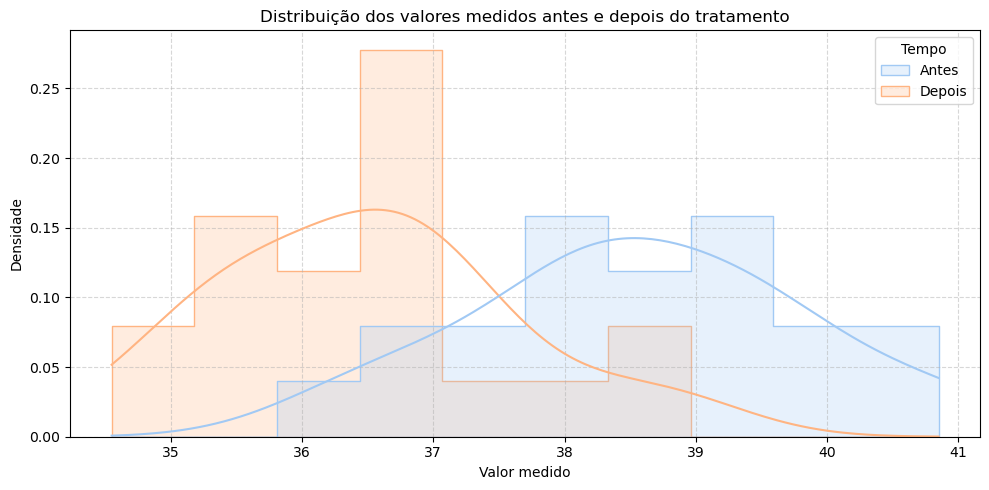

In [3]:
# Executa a função no DataFrame já gerado anteriormente
figura = plotar_distribuicoes(df)
figura

## Cálculo das Colunas para o Teste de Wilcoxon

Nesta etapa, foram computadas as colunas necessárias para a aplicação do **teste de Wilcoxon para amostras pareadas**. A partir dos valores medidos antes e depois do tratamento, foi calculada a **diferença** entre os pares, seu **valor absoluto**, o **sinal** da diferença, o **posto** correspondente (com base nos valores absolutos ranqueados) e o **posto com sinal**, que associa o valor do posto ao sinal da diferença. Essas transformações permitem aplicar o teste não paramétrico de forma estruturada, analisando se há predominância de diferenças positivas ou negativas de forma estatisticamente significativa. Esse preparo é fundamental para seguir com a etapa de inferência.

In [4]:
df = calcular_colunas_wilcoxon(df)
df

,Individuo,Antes,Depois,Diferença,Absoluto,Sinal,Posto,PostoSinal
0,1,39.45,38.49,-0.96,0.96,-,5.0,-5.0
1,2,38.62,36.54,-2.08,2.08,-,8.5,-8.5
2,3,39.64,36.88,-2.76,2.76,-,16.0,-16.0
3,4,40.78,35.16,-5.62,5.62,-,20.0,-20.0
4,5,38.50,36.17,-2.33,2.33,-,11.5,-11.5
5,6,38.50,36.93,-1.57,1.57,-,7.0,-7.0
6,7,40.85,35.48,-5.37,5.37,-,19.0,-19.0
7,8,39.80,37.23,-2.57,2.57,-,14.0,-14.0
8,9,38.19,36.11,-2.08,2.08,-,8.5,-8.5
9,10,39.51,36.46,-3.05,3.05,-,17.0,-17.0


## Resultado do Teste de Wilcoxon

Nesta etapa, são aplicadas as regras do teste de Wilcoxon para amostras pareadas. A função calcula a estatística do teste a partir da menor soma dos postos com sinal positivo ou negativo, levando em conta apenas as diferenças diferentes de zero entre os pares. Com base no número de pares válidos, é consultado o valor crítico correspondente ao nível de significância definido. A decisão de rejeitar ou não a hipótese nula é tomada comparando esse valor crítico com o valor observado da estatística de teste. Além disso, o valor-p é calculado para fornecer uma medida contínua da evidência contra a hipótese nula. O resultado final resume todas essas informações, permitindo uma interpretação estatística completa do efeito do tratamento.


In [5]:
estatisticas = aplicar_teste_wilcoxon(df, alpha = 0.05)
estatisticas

{'n pares válidos': 20,
 'W (estatística)': 11.0,
 'p-valor': 0.0001049041748046875,
 'T+': 11.0,
 'T-': 199.0,
 'T (min)': 11.0,
 'W crítico (α=0.05)': 59,
 'Rejeita H0?': True}

# Boxplot

O boxplot apresentado permite comparar a distribuição dos valores medidos antes e depois de uma intervenção. Cada caixa representa os quartis da distribuição (Q1, mediana e Q3), enquanto os pontos pretos indicam os dados individuais. A largura da caixa e a posição da mediana possibilitam visualizar alterações na tendência central e na dispersão entre os dois momentos. Esse tipo de gráfico é especialmente útil para detectar assimetrias, variações de amplitude interquartílica e possíveis outliers, complementando a análise estatística realizada com o teste de Wilcoxon.

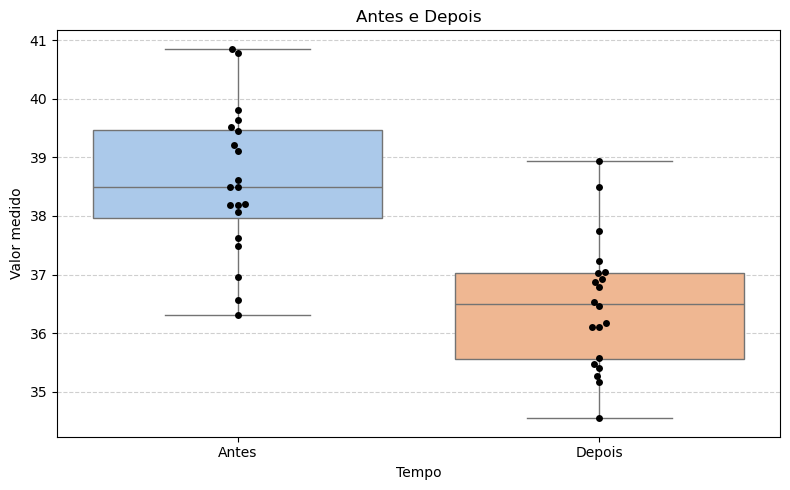

In [6]:
plotar_boxplot(df)